## Applying the XGBoost algorithm ##

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
import pandas as pd
import numpy as np

# from keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold
# from sklearn.preprocessing import StandardScaler # needed?
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
# from sklearn.pipeline import Pipeline
# import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# for reading files
import glob
import os
from datetime import datetime
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

In [81]:
# input dataset
input_file = "./drive/My Drive/remote_communities/data/all_combined_training.csv"
validation_file = "./drive/My Drive/remote_communities/data/all_combined_validation.csv"
# TODO: XGBoost parameters

In [168]:
# load data
df = pd.read_csv(input_file, index_col = 0)
dfc=df.copy()

In [169]:
dfc.tail(3) 
# dfc['year'].unique()

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C)
236518,2015,12,31,21,365.311750,60.01732,-70.02754,567,582.943444,-19.845023
236519,2015,12,31,22,361.482583,60.01732,-70.02754,567,582.943444,-20.679938
236520,2015,12,31,23,358.839000,60.01732,-70.02754,567,582.943444,-21.149695


In [170]:
dfc['date'] = pd.to_datetime(dfc[['year', 'month', 'day']])
# dfc.keys(), df.keys()
dfc.sample(2)

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),date
117940,2014,6,19,4,147.916667,59.31042,-69.59216,209,308.388576,0.408838,2014-06-19
76934,2015,10,13,14,967.215750,62.20071,-75.65000,1483,1347.844242,-8.297705,2015-10-13


In [171]:
dfc.rename(columns={"Temp (°C)":"Temp"}, inplace=True)
dfc.sample(2)

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp,date
188246,2013,6,28,13,498.739026,58.68000,-65.95000,942,756.806609,6.145898,2013-06-28
113459,2013,12,14,11,245.580000,59.31042,-69.59216,209,308.388576,-21.905554,2013-12-14


## Power consumption per capita

In [172]:
print(dfc['date'][236520])
dfc['date'][236520].weekday()

2015-12-31 00:00:00


3

In [173]:
dfc ['weekday'] = dfc['date'].dt.weekday

In [89]:
# def weekname_maker(weekday_number):
#   weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
#   return(weekdays[weekday_number])


# dfc["weekday_name"] = dfc["weekday"].apply(lambda x: weekname_maker(x))

In [174]:
dfc.head()

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp,date,weekday
0,2013,1,1,0,1314.522302,55.27987,-77.75458,686,1984.209328,-16.415625,2013-01-01,1
1,2013,1,1,1,1295.379198,55.27987,-77.75458,686,1984.209328,-17.082617,2013-01-01,1
2,2013,1,1,2,1281.408115,55.27987,-77.75458,686,1984.209328,-16.936621,2013-01-01,1
3,2013,1,1,3,1229.595401,55.27987,-77.75458,686,1984.209328,-17.152701,2013-01-01,1
4,2013,1,1,4,1184.894563,55.27987,-77.75458,686,1984.209328,-17.600867,2013-01-01,1


In [175]:
dfc['Kw_per_capita'] = dfc['Kw']/df['population']


In [176]:
dfc.drop(['Kw', 'population', 'annual_peak_load','year','month','day','lon'],
         axis = 1, inplace = True)
# I am maintaining lat, Kw_per_capita, date, temp, weekday_name and hour features
dfc.tail()

,hour,lat,Temp,date,weekday,Kw_per_capita
236516,19,60.01732,-19.957297,2015-12-31,3,0.640062
236517,20,60.01732,-20.051184,2015-12-31,3,0.648297
236518,21,60.01732,-19.845023,2015-12-31,3,0.644289
236519,22,60.01732,-20.679938,2015-12-31,3,0.637535
236520,23,60.01732,-21.149695,2015-12-31,3,0.632873


## Data by location: creates 9 dataframes df1...df9 to hold info for the 9 locations

In [177]:
# type(dfc['lat'].value_counts())
# dfc['lat'].value_counts().keys()
dfc['lat'].value_counts()

58.45424    26280
62.20071    26280
61.03000    26280
59.31042    26280
62.41657    26280
58.10006    26280
60.01732    26280
55.27987    26232
58.68000    26232
Name: lat, dtype: int64

In [178]:
# create a list of dataframe names
s=[]
for i in range(9):
    s.append('df'+str(i+1))
# print(s)

i=0
for key in dfc['lat'].value_counts().keys():
#     print(key)
    s[i]=dfc[dfc['lat']==key]
#     print(name.head(2))
#     print('\n')
    i=i+1


In [179]:
# s[0] is df1, s[1] is df2, .........
s[0].sample(5)

,hour,lat,Temp,date,weekday,Kw_per_capita
28878,6,58.45424,-15.272070,2013-04-19,4,0.506000
44820,12,58.45424,-33.301398,2015-02-12,3,0.915901
40380,12,58.45424,9.499170,2014-08-11,0,0.665394
30757,13,58.45424,4.074121,2013-07-06,5,0.517240
40248,0,58.45424,11.424951,2014-08-06,2,0.439964


### Aggregate the data by date, which means sum up all the hourly consumptions

Commenting the following aggregation to maintain hourly resolution

In [180]:
# df1=s[0].groupby('date')['Kw_per_capita'].sum().reset_index()
df1=s[0].sort_values(by=['date','hour'])
df1 = df1.reset_index()
# df1['date'].value_counts()
df1.head(10)

,index,hour,lat,Temp,date,weekday,Kw_per_capita
0,26280,0,58.45424,-18.211905,2013-01-01,1,0.586101
1,26281,1,58.45424,-18.678336,2013-01-01,1,0.579210
2,26282,2,58.45424,-18.978430,2013-01-01,1,0.562302
3,26283,3,58.45424,-18.901541,2013-01-01,1,0.555865
4,26284,4,58.45424,-19.094290,2013-01-01,1,0.544718
5,26285,5,58.45424,-18.904410,2013-01-01,1,0.541424
6,26286,6,58.45424,-19.061163,2013-01-01,1,0.535962
7,26287,7,58.45424,-19.123877,2013-01-01,1,0.557908
8,26288,8,58.45424,-19.240210,2013-01-01,1,0.560035
9,26289,9,58.45424,-19.228918,2013-01-01,1,0.556101


In [181]:
df1['index_number'] = list(df1.index)
df1.head()

,index,hour,lat,Temp,date,weekday,Kw_per_capita,index_number
0,26280,0,58.45424,-18.211905,2013-01-01,1,0.586101,0
1,26281,1,58.45424,-18.678336,2013-01-01,1,0.579210,1
2,26282,2,58.45424,-18.978430,2013-01-01,1,0.562302,2
3,26283,3,58.45424,-18.901541,2013-01-01,1,0.555865,3
4,26284,4,58.45424,-19.094290,2013-01-01,1,0.544718,4


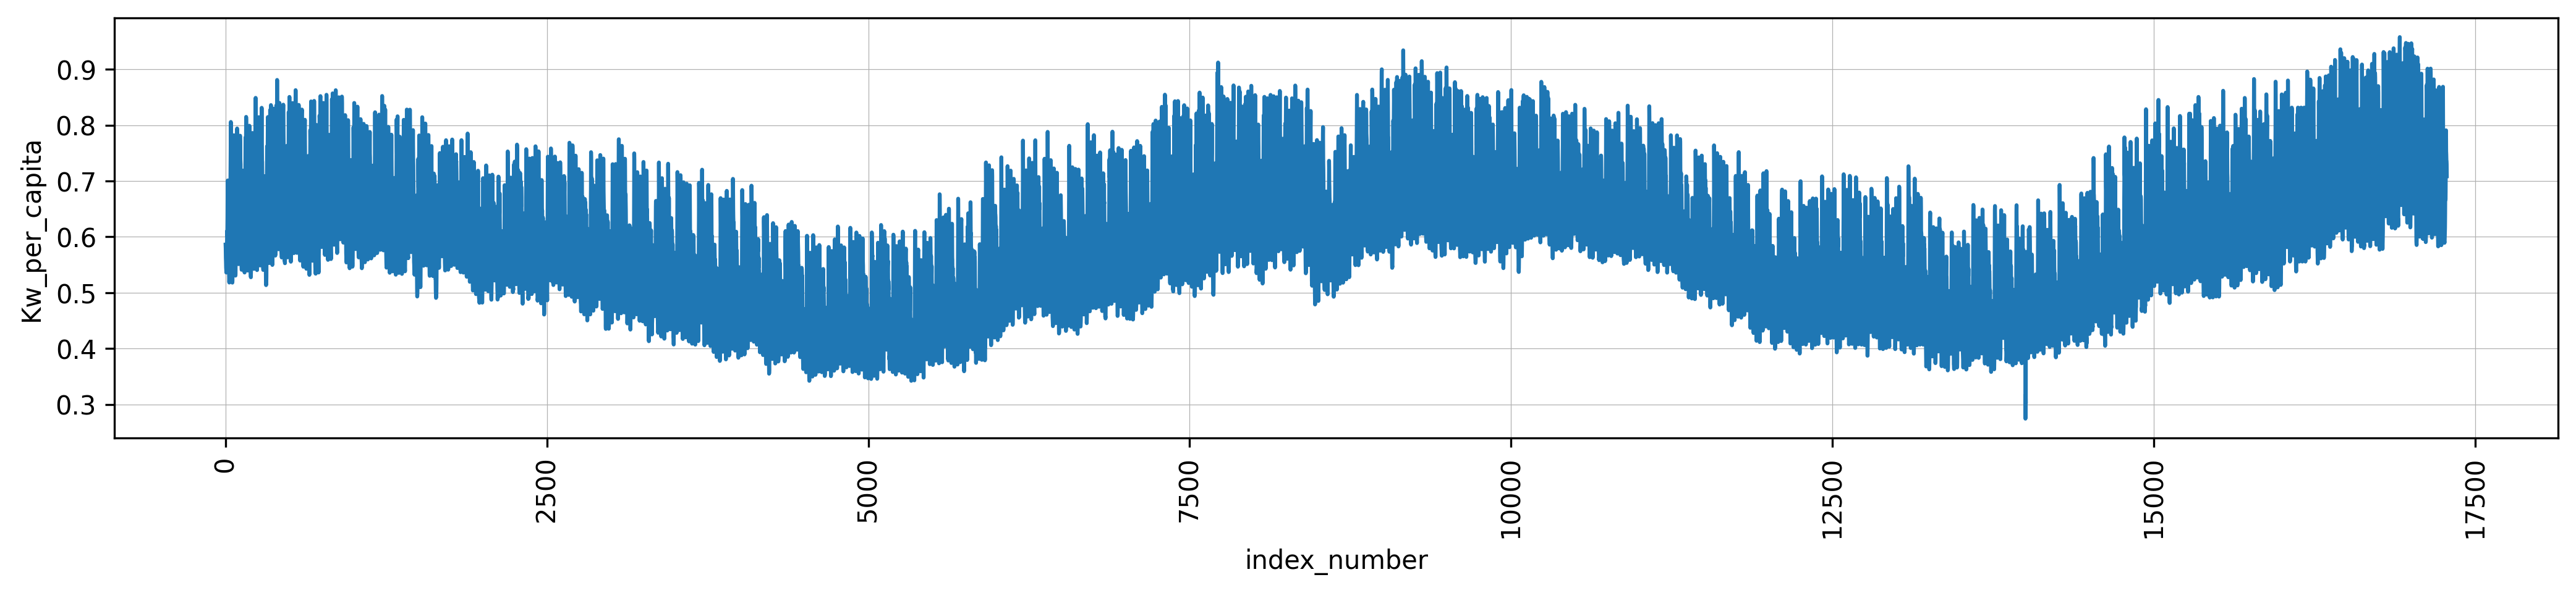

In [182]:
# plot time series
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df1.head(17280), x= 'index_number', y='Kw_per_capita')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
# dfc.keys()

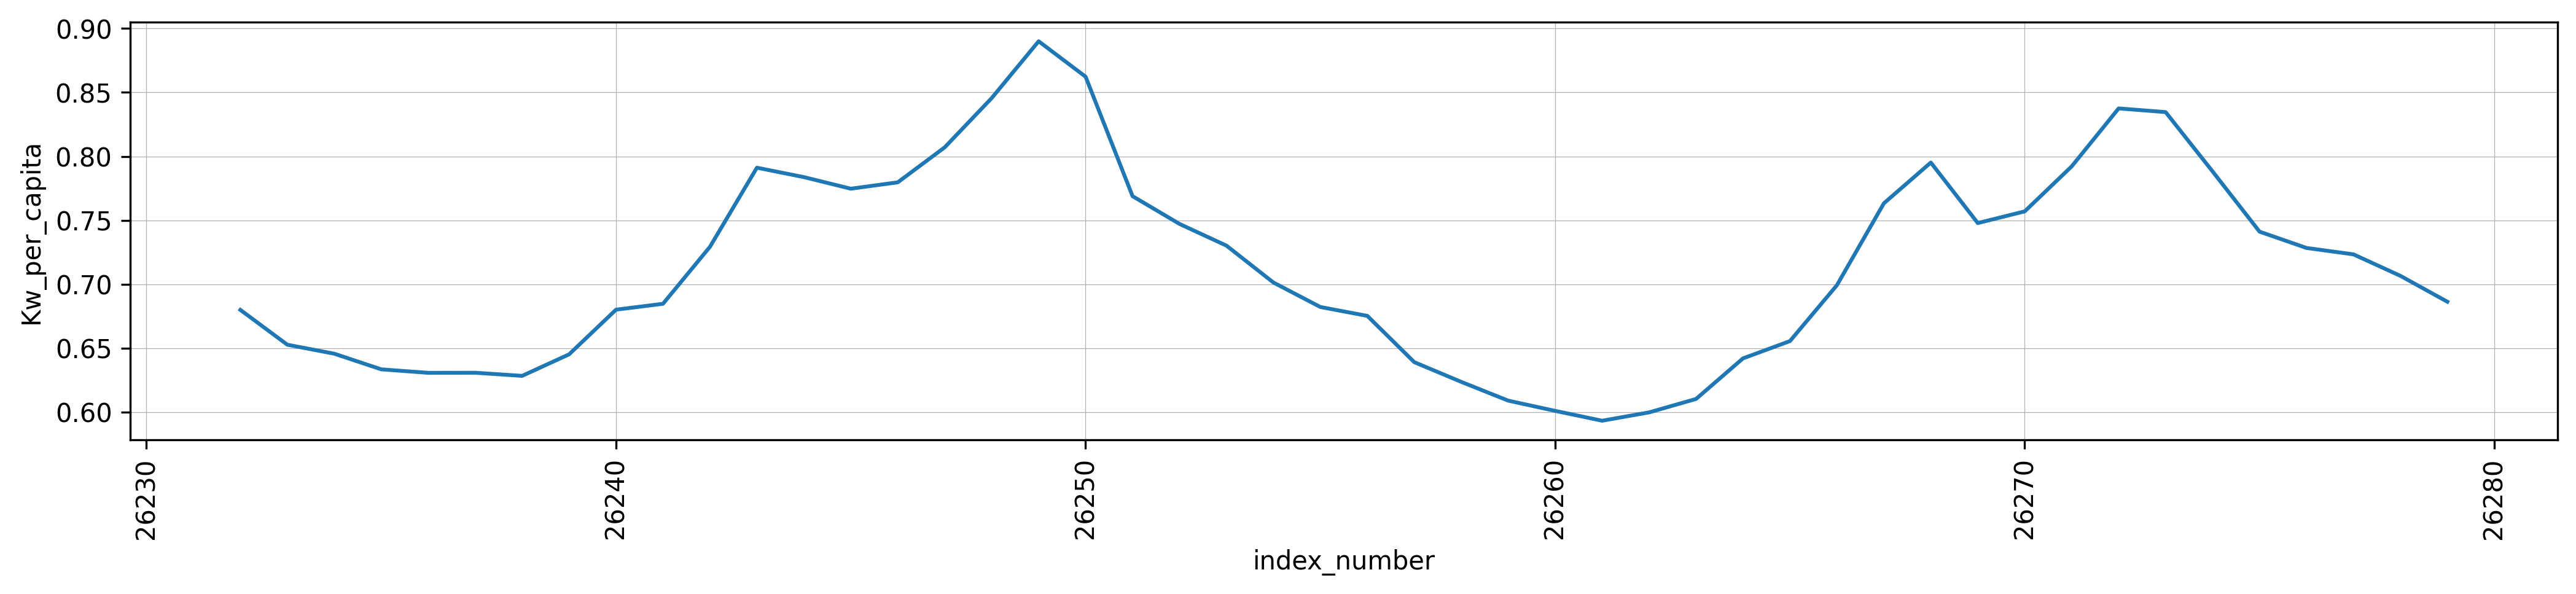

In [183]:
# plot time series
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df1.tail(48), x= 'index_number', y='Kw_per_capita')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
# dfc.keys()

In [184]:
# see if there are any missing values
df1.isna().sum()

index            0
hour             0
lat              0
Temp             0
date             0
weekday          0
Kw_per_capita    0
index_number     0
dtype: int64

## Feature engineering

In [185]:
df1[24:29]

,index,hour,lat,Temp,date,weekday,Kw_per_capita,index_number
24,26304,0,58.45424,-19.384024,2013-01-02,2,0.574695,24
25,26305,1,58.45424,-19.444266,2013-01-02,2,0.561368,25
26,26306,2,58.45424,-19.418188,2013-01-02,2,0.547498,26
27,26307,3,58.45424,-19.286749,2013-01-02,2,0.535184,27
28,26308,4,58.45424,-19.303625,2013-01-02,2,0.519964,28


In [ ]:
# df1['last7d']=df1['Kw_per_capita']
# for i in range(len(df1)-2):
#     s=df1['Kw_per_capita'][i]+df1['Kw_per_capita'][i+1]+df1['Kw_per_capita'][i+2]
# #     print(s)
#     df1['3d'][i+2]=s 

# df1.head(10)

In [186]:
# shit the Kw-per_capita column down 
df1_shift24h = df1.copy()
df1_shift24h['Kw_per_capita'] = df1_shift24h['Kw_per_capita'].shift(-24)
df1_shift24h.head()

,index,hour,lat,Temp,date,weekday,Kw_per_capita,index_number
0,26280,0,58.45424,-18.211905,2013-01-01,1,0.574695,0
1,26281,1,58.45424,-18.678336,2013-01-01,1,0.561368,1
2,26282,2,58.45424,-18.978430,2013-01-01,1,0.547498,2
3,26283,3,58.45424,-18.901541,2013-01-01,1,0.535184,3
4,26284,4,58.45424,-19.094290,2013-01-01,1,0.519964,4


In [187]:
df1_shift24h[-26:]

,index,hour,lat,Temp,date,weekday,Kw_per_capita,index_number
26254,52534,22,58.45424,-14.490088,2015-12-30,2,0.706639,26254
26255,52535,23,58.45424,-14.590430,2015-12-30,2,0.686411,26255
26256,52536,0,58.45424,-14.574316,2015-12-31,3,NaN,26256
26257,52537,1,58.45424,-14.905859,2015-12-31,3,NaN,26257
26258,52538,2,58.45424,-15.014258,2015-12-31,3,NaN,26258
26259,52539,3,58.45424,-15.161230,2015-12-31,3,NaN,26259
26260,52540,4,58.45424,-15.203711,2015-12-31,3,NaN,26260
26261,52541,5,58.45424,-15.160010,2015-12-31,3,NaN,26261
26262,52542,6,58.45424,-15.172949,2015-12-31,3,NaN,26262
26263,52543,7,58.45424,-15.464697,2015-12-31,3,NaN,26263


In [188]:
# Remove the last 24 rows of the dataframe

df1_shift24h = df1_shift24h[:len(df1_shift24h)-24]
df1_shift24h.tail()

,index,hour,lat,Temp,date,weekday,Kw_per_capita,index_number
26251,52531,19,58.45424,-15.029150,2015-12-30,2,0.741177,26251
26252,52532,20,58.45424,-14.900488,2015-12-30,2,0.728437,26252
26253,52533,21,58.45424,-15.035010,2015-12-30,2,0.723428,26253
26254,52534,22,58.45424,-14.490088,2015-12-30,2,0.706639,26254
26255,52535,23,58.45424,-14.590430,2015-12-30,2,0.686411,26255


In [193]:
# count the number of days
# total_days = len(np.unique(df1_shift24h['date']))
# print(total_days)
total_days = len(df1_shift24h)/24
print(total_days)

1094.0


In [190]:
# remove further unnecessary features
df1_shift24h.drop(['index','lat','date','index_number'], axis=1, inplace=True)
df1_shift24h.head()

,hour,Temp,weekday,Kw_per_capita
0,0,-18.211905,1,0.574695
1,1,-18.678336,1,0.561368
2,2,-18.978430,1,0.547498
3,3,-18.901541,1,0.535184
4,4,-19.094290,1,0.519964


In [ ]:
# df1['6d']=df1['Kw_per_capita']
# for i in range(len(df1)-5):
#     s=df1['Kw_per_capita'][i]+df1['Kw_per_capita'][i+1]+df1['Kw_per_capita'][i+2]+df1['Kw_per_capita'][i+3]+df1['Kw_per_capita'][i+4]+df1['Kw_per_capita'][i+5]
# #     print(s)
#     df1['6d'][i+5]=s

<ipython-input-246-0f85e953f98d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['6d'][i+5]=s


In [ ]:
df1.head(10)

,date,Kw_per_capita,3d,6d
0,2013-01-01,17.345227,17.345227,17.345227
1,2013-01-02,18.375069,18.375069,18.375069
2,2013-01-03,18.837546,54.557842,18.837546
3,2013-01-04,19.345942,56.558557,19.345942
4,2013-01-05,18.816000,56.999489,18.816000
5,2013-01-06,18.555877,56.717819,111.275661
6,2013-01-07,19.918158,57.290035,113.848592
7,2013-01-08,20.430565,58.904600,115.904089
8,2013-01-09,19.658347,60.007070,116.724889
9,2013-01-10,20.177576,60.266488,117.556523


## Train-test split
**Problems:**
- ***we CAN't randomly split a time series with train_test_split(), because the split will randomly select points of time that appear in our train/test data set, which means the time is not continuous, or create gaps in time, this will disrupt the potential correlation exists in a time series.***
- the best to way to train-test split a time series is just take the early 80% as the train data, the following 20% as test data

In [195]:
# determin the train-test split point

split_day = round(total_days*0.8,0)
print(split_day)
split_hour = split_day * 24
print(split_hour)

875.0
21000.0


In [198]:
# alternative train-test split 
# train_dataset, test_dataset = train_test_split(dfc, test_size=0.2)
train_data = df1_shift24h[:int(split_hour)]
test_data = df1_shift24h[int(split_hour):]

In [199]:
# train_data.sample(2)
test_data.sample(2)

,hour,Temp,weekday,Kw_per_capita
22882,10,10.450830,2,0.636248
21480,0,7.874902,0,0.497713


In [200]:
# create input and output variables datasets
X_train = train_data.copy()
X_test = test_data.copy()

y_train = X_train.pop('Kw_per_capita')
y_test = X_test.pop('Kw_per_capita')

# get the values from the dataframe - the result is a numpy array
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

# TODO: explore if we need to construct a DMatrix as the input to XGBoost

train = train = xgb.DMatrix(X_train, label = y_train)  
test = xgb.DMatrix(X_test, label = y_test)

# Reshape the arrays for the predicted variable
# TODO: is this needed here?
y_train = np.reshape(y_train, (-1,1))
y_test = np.reshape(y_test, (-1,1))

In [ ]:
# X_train = train_data.copy().drop(columns=['date','Kw_per_capita'])
# X_test = test_data.copy().drop(columns=['date','Kw_per_capita'])

# y_train = train_data.copy().pop('Kw_per_capita')
# y_test = test_data.copy().pop('Kw_per_capita')

In [202]:
# X_train.sample(3)
# y_train.sample(3)

In [203]:
# define the MAPE metric
def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [204]:
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 500, max_depth=2,  seed = 123)
  
# Fitting the model
xgb_r.fit(X_train, y_train)

XGBRegressor(max_depth=2, n_estimators=500, objective='reg:squarederror',
             seed=123)

In [205]:
# xgb_r = xgb.XGBRegressor(objective ='reg:squarederror',
#                   n_estimators = 500, seed = 123)
  
# xgb_r.fit(X_train, y_train)
# xgb_r.fit(X_train, 
#           y_train, 
#          eval_set=[(X_train, y_train),(X_test, y_test)],
#          eval_metric='mae')
  


In [206]:
# Predictions on the train dataset
train_pred = xgb_r.predict(X_train)

# MAE Computation
train_mae = mean_absolute_error(y_train, train_pred)
print("MAE:  % f" %(train_mae))

# RMSE Computation
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
print("RMSE: % f" %(train_rmse))

MAE:   0.046562
RMSE:  0.057604


In [207]:
test_pred = xgb_r.predict(X_test)
  
# MAE Computation
test_mae = mean_absolute_error(y_test, test_pred)
print("MAE:  % f" %(test_mae))

# RMSE Computation
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print("RMSE : % f" %(test_rmse))

MAE:   0.065165
RMSE :  0.077045


In [212]:
# create predictions dataframe for visualization

len(test_pred)

5256

In [219]:
test_index_number = [i for i in range(21000,26256)]
print(len(test_index_number))
test_index_number[-3:]

5256


[26253, 26254, 26255]

In [220]:
predictions_dict = {'predictions':test_pred, 'test_index':test_index_number}
df_predictions = pd.DataFrame(predictions_dict)
df_predictions.tail()

,predictions,test_index
5251,0.764358,26251
5252,0.753005,26252
5253,0.744349,26253
5254,0.718171,26254
5255,0.679606,26255


In [208]:
# Check the means of the datasets to help interpret the RMSE values

print("Average Kw in the training dataset:  ", train_data['Kw_per_capita'].mean())
print("Average Kw in the test dataset:      ", test_data['Kw_per_capita'].mean())

Average Kw in the training dataset:   0.6322455072231343
Average Kw in the test dataset:       0.6288950324054088


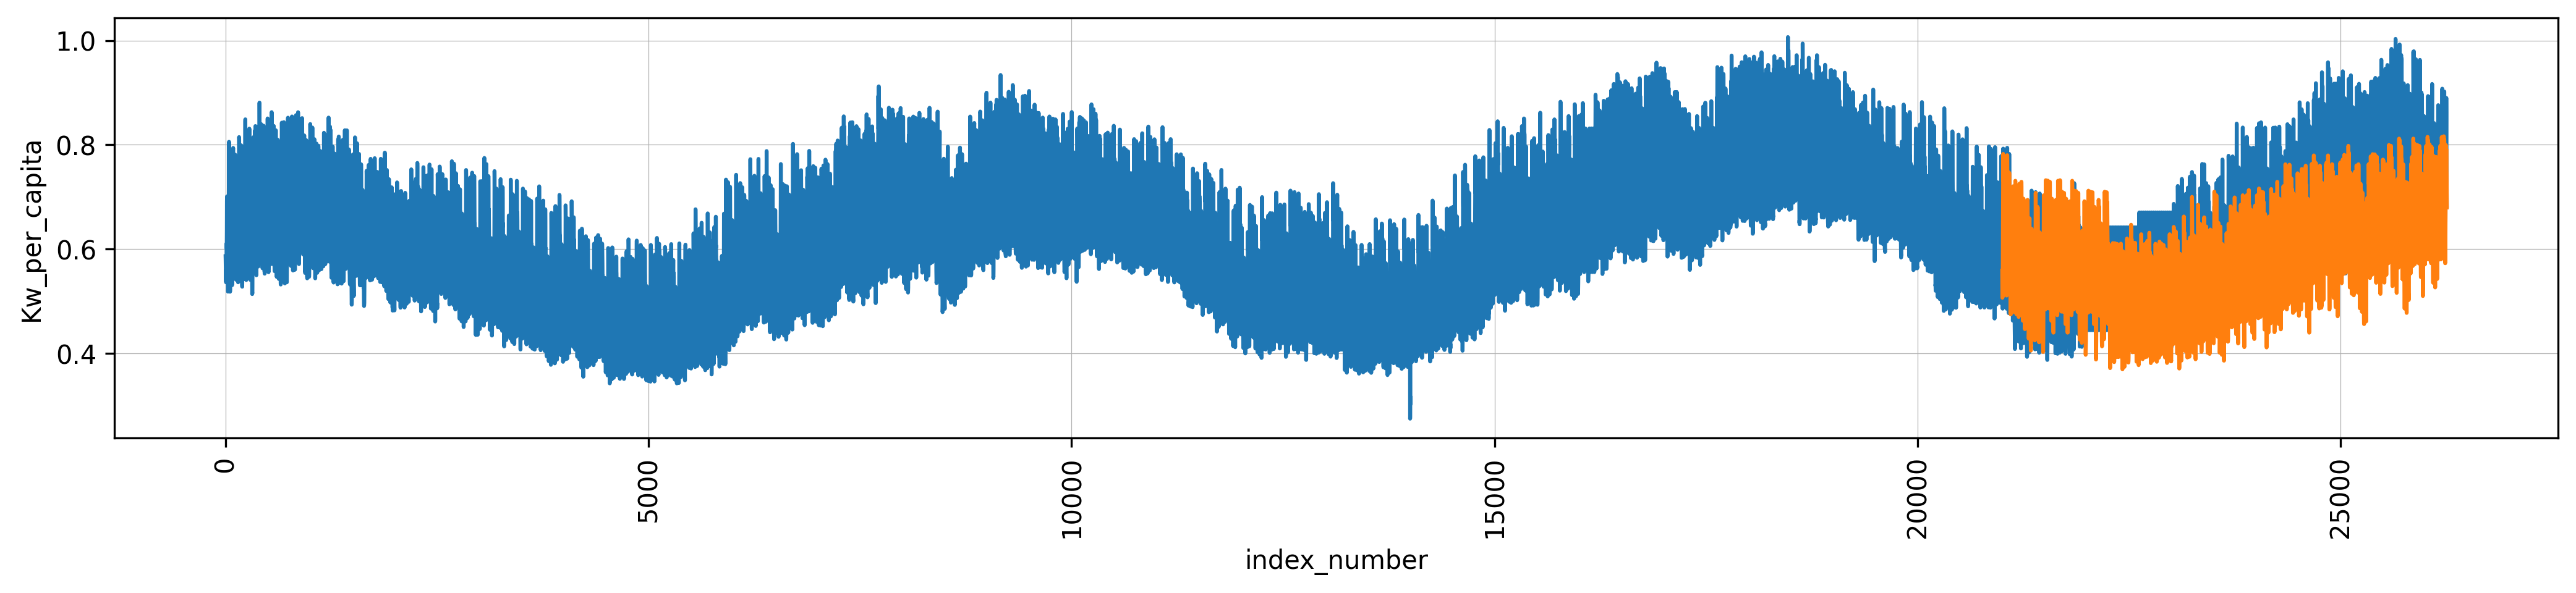

In [221]:
# plot time series
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df1[:len(df1)-24], x= 'index_number', y='Kw_per_capita')
sns.lineplot(data=df_predictions, x= 'test_index', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
# dfc.keys()

In [ ]:
# # Predictions on the train dataset
# train_pred = xgb_r.predict(X_train)
# # RMSE Computation
# train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
# print("RMSE : % f" %(train_rmse))
# train_pred[-5:-1]

RMSE :  0.008408


array([14.233408, 13.460885, 13.065323, 14.28152 ], dtype=float32)

In [ ]:
# # Predictions on the train dataset
# test_pred = xgb_r.predict(X_test)
# # RMSE Computation
# test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
# print("RMSE : % f" %(test_rmse))
# test_pred[-5:-1]

RMSE :  0.754349


array([18.11816 , 18.33556 , 18.952381, 18.986805], dtype=float32)